In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os
import statistics

## Reading Data

In [2]:
PATH = "../data/finals_game_engines"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [3]:
file_data = []
diff_means = []
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}", index_col=False)
    file_data.append(data_in)
    
data_original = pd.concat(file_data)

## Cleanup Data

In [4]:
# negative diff
negative_diffs_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['diff'] < 0)]['id'].count()
negative_diffs_windup = data_original[(data_original['program'] == 'windup') & (data_original['diff'] < 0)]['id'].count()

# no result of measurement program
no_result_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['fw'] == -1)]['id'].count()
no_result_windup = data_original[(data_original['program'] == 'windup') & (data_original['fw'] == -1)]['id'].count()

# exclude this from our data
data = data_original[(data_original['diff'] > 0) & (data_original['fw'] != -1)]

In [5]:
print(no_result_getpixel)

800


In [6]:
diff_validation = pd.DataFrame(index=['GETPIXEL', 'DESKDUP', 'Total'], columns=['negative', 'no result', 'Total'])
diff_validation['negative']['GETPIXEL'] = negative_diffs_getpixel
diff_validation['no result']['GETPIXEL'] = no_result_getpixel
diff_validation['Total']['GETPIXEL'] = negative_diffs_getpixel + no_result_getpixel

diff_validation['negative']['DESKDUP'] = negative_diffs_windup
diff_validation['no result']['DESKDUP'] = no_result_windup
diff_validation['Total']['DESKDUP'] = negative_diffs_windup + no_result_windup

diff_validation['negative']['Total'] = negative_diffs_getpixel + negative_diffs_windup
diff_validation['no result']['Total'] = no_result_getpixel + no_result_windup
diff_validation['Total']['Total'] = negative_diffs_getpixel + no_result_getpixel + negative_diffs_windup + no_result_windup


print(diff_validation.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))


diff_validation

\begin{tabular}{llll}
\toprule
 & negative & no result & Total \\
\midrule
GETPIXEL & 39 & 800 & 839 \\
DESKDUP & 1349 & 0 & 1349 \\
Total & 1388 & 800 & 2188 \\
\bottomrule
\end{tabular}



,negative,no result,Total
GETPIXEL,39,800,839
DESKDUP,1349,0,1349
Total,1388,800,2188


## z-Value Removal

In [7]:
frameworks = data_original['framework'].unique()
programs = data_original['program'].unique()

valids = []
for program in programs:
    for framework in frameworks:
        valid_temp = {}
        valid_temp['program'] = program
        valid_temp['framework'] = framework
        valid_temp['mean'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].mean()
        valid_temp['std'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].std()
        valids.append(valid_temp)

valid = pd.DataFrame.from_dict(valids)
valid

,program,framework,mean,std
0,getpixel,Godot,NaN,NaN
1,getpixel,Unity,2343.539052,748.255071
2,getpixel,UnrealEngine5,2137.944872,610.678487
3,none,Godot,NaN,NaN
4,none,Unity,NaN,NaN
5,none,UnrealEngine5,NaN,NaN
6,windup,Godot,2784.948617,1144.904559
7,windup,Unity,1442.013423,750.387165
8,windup,UnrealEngine5,NaN,NaN


In [8]:
agg_means = {}
stds = {}
for program in programs:
    agg_means[program] = valid[valid['program'] == program]['mean'].mean()
    stds[program] = valid[valid['program'] == program]['mean'].std()

In [9]:
combination_to_remove = []

In [10]:
# getpixel
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'getpixel') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} getpixel')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['getpixel'] + (0.5 * stds['getpixel'] * 3)) or (fw_mean < agg_means['getpixel'] - (0.5 * stds['getpixel'] * 3)):
            print(f'exclude {framework} getpixel')
            combination_to_remove.append({'program' : 'getpixel', 'framework' : framework})
        else:
            print(f'valid for {framework} getpixel')

already excluded Godot getpixel
valid for Unity getpixel
valid for UnrealEngine5 getpixel


In [11]:
# windup
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'windup') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} windup')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['windup'] + (0.5 * stds['windup'] * 3)) or (fw_mean < agg_means['windup'] - (0.5 * stds['windup'] * 3)):
            print(f'exclude {framework} windup')
            combination_to_remove.append({'program' : 'windup', 'framework' : framework})
        else:
            print(f'valid for {framework} windup')

valid for Godot windup
valid for Unity windup
already excluded UnrealEngine5 windup


In [12]:
# exclude from data based on z-value removal
for combination in combination_to_remove:
    data = data.loc[~((data['program'] == combination['program']) & (data['framework'] == combination['framework']))] 

In [13]:
# print(f'negative diffs: {len(data_getpixel[data_getpixel['diff'] < 0])}')
# print(f'negative diffs for frameworks: {data_getpixel[data_getpixel['diff'] < 0]['framework'].unique()}')

# print(f'diffs outlying (>10ms): {len(data_getpixel[data_getpixel['diff'] > 10])}')
# print(f'diffs outlying (>10ms) for frameworks: {data_getpixel[data_getpixel['diff'] > 10]['framework'].unique()}')

# print(f'program could not measure {len(data_getpixel[data_getpixel['fw'] < 0])} times')
# print(f'program could not measure for frameworks: {data_getpixel[data_getpixel['fw'] < 0]['framework'].unique()}')


In [14]:
# print(f'negative diffs: {len(data_windup[data_windup['diff'] < 0])}')
# print(f'negative diffs for frameworks: {data_windup[data_windup['diff'] < 0]['framework'].unique()}')

# print(f'diffs outlying (>10ms): {len(data_windup[data_windup['diff'] > 10])}')
# print(f'diffs outlying (>10ms) for frameworks: {data_windup[data_windup['diff'] > 10]['framework'].unique()}')

# print(f'program could not measure {len(data_windup[data_windup['fw'] < 0])} times')
# print(f'program could not measure for frameworks: {data_windup[data_windup['fw'] < 0]['framework'].unique()}')

## EtE-Validation

In [15]:
# end-to-end latency validation
data_none = data_original[data_original['program'] == 'none']
data_getpixel = data[data['program'] == 'getpixel']
data_windup = data[data['program'] == 'windup']

median_ete_none = data_none['ete_upper'].median()
sd_ete_none = data_none['ete_upper'].std()
median_ete_getpixel = data_getpixel['ete_upper'].median()
sd_ete_getpixel = data_getpixel['ete_upper'].std()
median_ete_windup = data_windup['ete_upper'].median()
sd_ete_windup = data_windup['ete_upper'].std()

print(f'none --- median: {median_ete_none}, std: {sd_ete_none}')
print(f'getpixel --- median: {median_ete_getpixel}, std: {sd_ete_getpixel}')
print(f'windup --- median: {median_ete_windup}, std: {sd_ete_windup}')


none --- median: 37347.0, std: 51251.40830210645
getpixel --- median: 52912.0, std: 58163.312711644656
windup --- median: 6650.0, std: 33933.78040721246


## Plotting Results

In [16]:
COLOR_GLUTROT = '#DA3C43'
COLOR_HEIDENELKE = '#9C004B'

COLOR_BLUE= '#5CABFF'
COLOR_DARKBLUE = '#18206F'

COLOR_GREEN = '#7dff1a'
COLOR_DARKGREEN = '#4FB800'

COLOR_OCKER_ANDI = '#ebb300'
COLOR_OCKER = '#EC7F00'

COLOR_NONE = '#8E8E8D'

PALETTE_LIGHT = [COLOR_BLUE, COLOR_GREEN, COLOR_GLUTROT, COLOR_OCKER_ANDI]
PALETTE_DARK = [COLOR_DARKBLUE, COLOR_DARKGREEN, COLOR_HEIDENELKE, COLOR_OCKER]

In [17]:
data['ete_upper'] = data['ete_upper'] / 1000
data['ete_lower'] = data['ete_lower'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000
data = data[data['program'] != 'none']
data

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_2960\3119544198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ete_upper'] = data['ete_upper'] / 1000
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_2960\3119544198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ete_lower'] = data['ete_lower'] / 1000
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_2960\3119544198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,3902,Godot,3D,Godot_3D,fullscreen,3.0,windup,68.029,0.570,64.712,3.317
1,1,1,3902,Godot,3D,Godot_3D,fullscreen,3.0,windup,70.535,0.532,64.908,5.627
2,2,2,3902,Godot,3D,Godot_3D,fullscreen,3.0,windup,68.997,1.042,65.144,3.853
3,3,3,3902,Godot,3D,Godot_3D,fullscreen,3.0,windup,66.429,2.260,64.809,1.620
4,4,4,3902,Godot,3D,Godot_3D,fullscreen,3.0,windup,70.209,0.190,65.485,4.724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2695,UnrealEngine5,rects,UnrealEngine5_rects,fullscreen,3.0,getpixel,185.823,185.465,185.543,0.280
196,196,196,2695,UnrealEngine5,rects,UnrealEngine5_rects,fullscreen,3.0,getpixel,192.465,192.097,189.833,2.632
197,197,197,2695,UnrealEngine5,rects,UnrealEngine5_rects,fullscreen,3.0,getpixel,194.848,194.488,192.247,2.601
198,198,198,2695,UnrealEngine5,rects,UnrealEngine5_rects,fullscreen,3.0,getpixel,186.357,187.858,184.597,1.760


[<matplotlib.lines.Line2D object at 0x00000154336D3740>, <matplotlib.lines.Line2D object at 0x00000154336D39E0>, <matplotlib.lines.Line2D object at 0x00000154336D3A70>, <matplotlib.lines.Line2D object at 0x000001543369FAA0>, <matplotlib.lines.Line2D object at 0x000001543376C4A0>, <matplotlib.lines.Line2D object at 0x0000015433798710>, <matplotlib.lines.Line2D object at 0x000001543379B980>, <matplotlib.lines.Line2D object at 0x0000015433798230>]
['default', 'image', 'rects', '3D', 'default', 'image', 'rects', '3D']


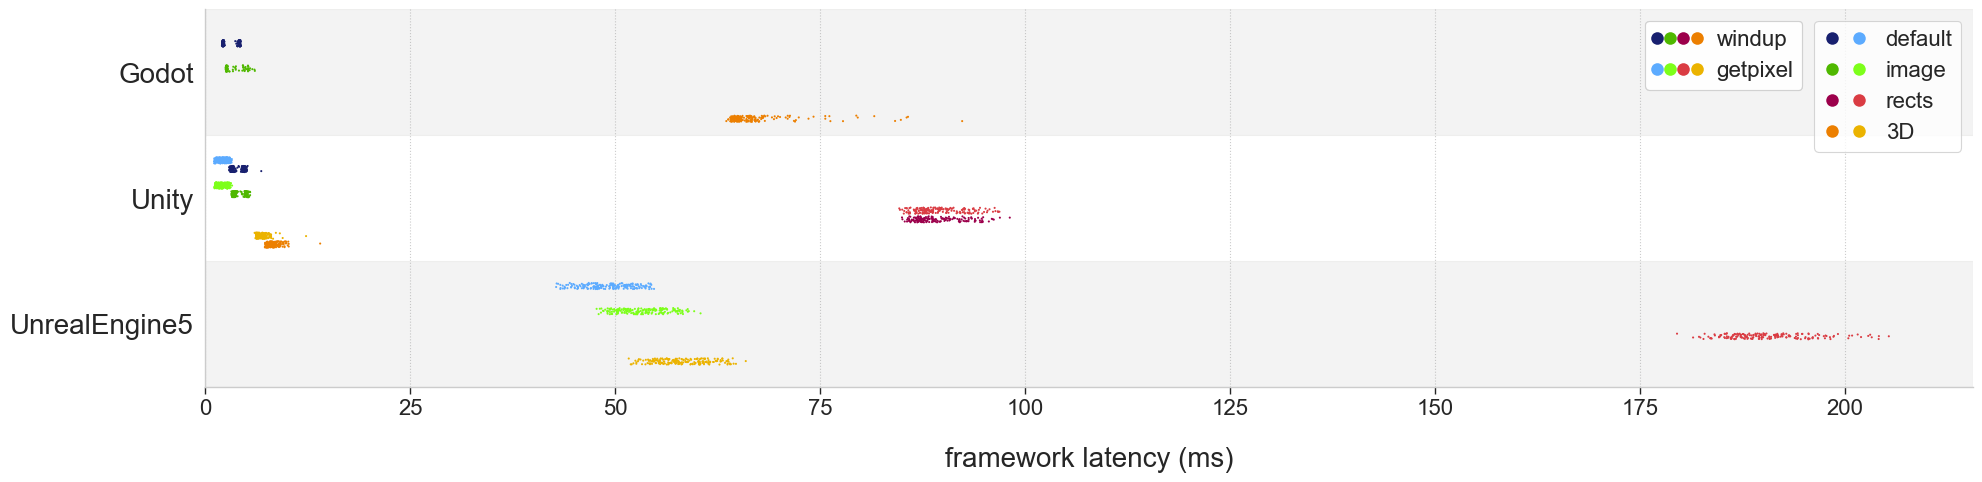

In [18]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(20, 5), "xtick.bottom": True, "grid.linestyle": ":"})

offset = lambda p: transforms.ScaledTranslation(0, p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

sns.stripplot(data=data[data['program'] == 'windup'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects', '3D'], dodge=True, palette=PALETTE_DARK, size=1.5, transform=offset(0.05)+trans)
plot = sns.stripplot(data=data[data['program'] == 'getpixel'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects', '3D'], dodge=True, palette=PALETTE_LIGHT, size=1.5)

# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        plot.axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
plot.set_ylim(-0.5, len(data['framework'].unique()) - 0.5)

# increase label size
plot.set_xlabel('framework latency (ms)', fontsize=20)
plot.xaxis.labelpad = 20
plot.set_ylabel('')

plot.set_xlim(left=0)
plot.tick_params(axis='y', labelsize=20)
plot.tick_params(axis='x', labelsize=16)
plt.legend(title='', fontsize=20, loc='upper right')

handles, labels = plot.get_legend_handles_labels()
print(handles)
print(labels)

handles_windup = (handles[0], handles[1], handles[2], handles[3])
handles_getpixel = (handles[4], handles[5], handles[6], handles[7])

handles_default = (handles[0], handles[4])
handles_image = (handles[1], handles[5])
handles_rects = (handles[2], handles[6])
handles_3d = (handles[3], handles[7])

condition_legend = plot.legend([handles_default, handles_image, handles_rects, handles_3d], ['default', 'image', 'rects', '3D'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16)
program_legend = plot.legend([handles_windup, handles_getpixel], ['windup', 'getpixel'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0.91, 1), fontsize=16)
plt.gca().add_artist(condition_legend)
plt.gca().add_artist(program_legend)

plt.gca().invert_yaxis()
sns.despine(bottom = False, left = False)
plt.tight_layout()
plt.savefig("./figures/game_engines_results.pdf", format='pdf')

In [19]:
# sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 5), "xtick.bottom": True, "grid.linestyle": ":"})

# plot = sns.stripplot(data=data[data['framework']=='UnrealEngine5'], x='program', y='diff', hue='complexity', size=2, dodge=True, palette=[COLOR_BLUE, COLOR_GLUTROT, 'orange', 'green'])
# # plot = sns.boxplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# # plot.axes.set_ylim(-25, 50)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)